In [46]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
# load dataset
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/hotel.csv')

In [48]:
#buang kolom
df = df.drop(columns=['User_ID', 'Browser_Used', 'Device_Used']) 

In [49]:
#menampilkan data
df

,Description,Is_Response
0,The room was kind of clean but had a VERY stro...,not happy
1,I stayed at the Crown Plaza April -- - April -...,not happy
2,I booked this hotel through Hotwire at the low...,not happy
3,Stayed here with husband and sons on the way t...,happy
4,My girlfriends and I stayed here to celebrate ...,not happy
...,...,...
38927,We arrived late at night and walked in to a ch...,happy
38928,The only positive impression is location and p...,not happy
38929,Traveling with friends for shopping and a show...,not happy
38930,The experience was just ok. We paid extra for ...,not happy


In [50]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95):
      print("\nStop training data, akurasi > 95%")
      self.model.stop_training = True

callbacks = myCallback()

In [51]:
#one-hot-encoding dan membuat dataframe baru
category = pd.get_dummies(df.Is_Response)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='Is_Response')
df_baru

,Description,happy,not happy
0,The room was kind of clean but had a VERY stro...,0,1
1,I stayed at the Crown Plaza April -- - April -...,0,1
2,I booked this hotel through Hotwire at the low...,0,1
3,Stayed here with husband and sons on the way t...,1,0
4,My girlfriends and I stayed here to celebrate ...,0,1
...,...,...,...
38927,We arrived late at night and walked in to a ch...,1,0
38928,The only positive impression is location and p...,0,1
38929,Traveling with friends for shopping and a show...,0,1
38930,The experience was just ok. We paid extra for ...,0,1


In [52]:
#split dataframe
review = df_baru['Description'].values
label = df_baru[['happy', 'not happy']].values

review

array(["The room was kind of clean but had a VERY strong smell of dogs. Generally below average but ok for a overnight stay if you're not too fussy. Would consider staying again if the price was right. Breakfast was free and just about better than nothing.",
       "I stayed at the Crown Plaza April -- - April --, ----. The staff was friendly and attentive. The elevators are tiny (about -' by -'). The food in the restaurant was delicious but priced a little on the high side. Of course this is Washington DC. There is no pool and little for children to do. My room on the fifth floor had two comfortable beds and plenty of space for one person. The TV is a little small by todays standards with a limited number of channels. There was a small bit of mold in the bathtub area that could have been removed with a little bleach. It appeared the carpets were not vacummed every day. I reported a light bulb was burned out. It was never replaced. Ice machines are on the odd numbered floors, but the o

In [53]:
label

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]], dtype=uint8)

In [54]:
from sklearn.model_selection import train_test_split

text = df_baru['Description'].values
y = df_baru[['happy', 'not happy']].values
text_train, text_test, y_train, y_test = train_test_split(text, y, test_size = 0.2)

In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#tokenizer
tokenizer = Tokenizer(num_words = 280617, oov_token = '-')
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_test)

#sequences
seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

#padding
pad_train = pad_sequences(seq_train, maxlen = 300, padding = 'post', truncating = 'post')

pad_test = pad_sequences(seq_test, maxlen = 300, padding = 'post', truncating = 'post')

In [56]:
#embedding
from tensorflow.keras import layers
from tensorflow.keras import Sequential

model = Sequential([layers.Embedding(280617, 64, input_length = 300),
                    layers.LSTM(64, dropout = 0.1),
                    layers.Dense(128, activation = 'relu'),
                    layers.Dense(64, activation = 'relu'),
                    layers.Dense(2, activation = 'sigmoid')
                    ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 64)           17959488  
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
Total params: 18,009,218
Trainable params: 18,009,218
Non-trainable params: 0
_________________________________________________________________


In [58]:
#training
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

history = model.fit(pad_train, 
                    y_train, 
                    batch_size = 128, 
                    epochs = 30,
                    validation_data = (pad_test, y_test),
                    verbose = 2,
                    callbacks = [callbacks])

Epoch 1/30
244/244 - 142s - loss: 0.2381 - accuracy: 0.9115 - val_loss: 0.3775 - val_accuracy: 0.8661 - 142s/epoch - 582ms/step
Epoch 2/30
244/244 - 139s - loss: 0.2034 - accuracy: 0.9258 - val_loss: 0.3967 - val_accuracy: 0.8697 - 139s/epoch - 568ms/step
Epoch 3/30
244/244 - 139s - loss: 0.1750 - accuracy: 0.9385 - val_loss: 0.4108 - val_accuracy: 0.8663 - 139s/epoch - 568ms/step
Epoch 4/30
244/244 - 139s - loss: 0.1499 - accuracy: 0.9480 - val_loss: 0.4226 - val_accuracy: 0.8630 - 139s/epoch - 570ms/step
Epoch 5/30

Stop training data, akurasi > 95%
244/244 - 139s - loss: 0.1177 - accuracy: 0.9615 - val_loss: 0.4588 - val_accuracy: 0.8617 - 139s/epoch - 570ms/step


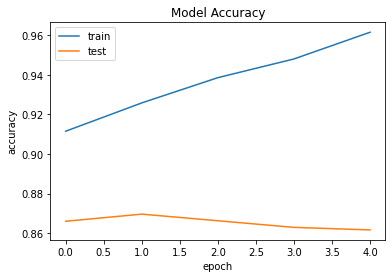

In [59]:
#grafik model accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

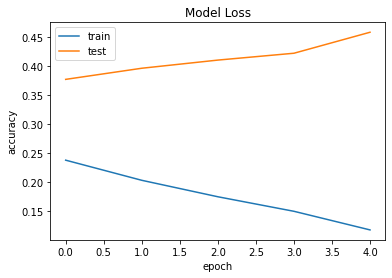

In [60]:
#grafik model loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()